In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


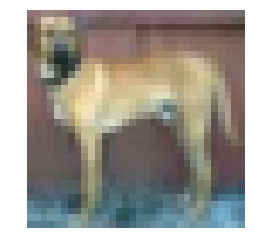

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_learning_rate():
    return tf.placeholder(tf.float32, None, name="learning_rate")

In [20]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [21]:
def conv_net_is_training_placeholder():
    return tf.placeholder(tf.bool)

In [22]:
def flatten(tensor):
    conv_output_shape = tensor.get_shape().as_list()
    return tf.reshape(tensor, [-1, conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]])

In [23]:
def conv_net(inputs, keep_prob, is_training):   
    # Conv Layer - 1, Input 32x32x3, MaxPool 2, Dropout, Output 16x16x32
    conv1_layer = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=3,
                                   strides=1, padding="SAME", activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer, pool_size=[2, 2], strides=2)
    conv1_layer_dropout = tf.layers.dropout(inputs=conv1_layer_mpool, rate=keep_prob)
    
    # Conv Layer - 2, Input 16x16x32, MaxPool 2, Dropout, Output 8x8x32
    conv2_layer = tf.layers.conv2d(inputs=conv1_layer_dropout, filters=32, kernel_size=3, 
                                   strides=1, padding="SAME", activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer, pool_size=[2, 2], strides=2)
    conv2_layer_dropout = tf.layers.dropout(inputs=conv2_layer_mpool, rate=keep_prob)
    
    # Conv Layer - 3, Input 8x8x32, MaxPool 2, Dropout, Output 4x4x64
    conv3_layer = tf.layers.conv2d(inputs=conv2_layer_dropout, filters=64, kernel_size=3, 
                                   strides=1, padding="SAME", activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    
    conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer, pool_size=[2, 2], strides=2)
    conv3_layer_dropout = tf.layers.dropout(inputs=conv3_layer_mpool, rate=keep_prob)
    
    # Conv Layer Flattened
    flatten_conv_output = flatten(conv3_layer_dropout)

    # Dense Layer 1 - Size 256
    dense1_layer = tf.layers.dense(inputs=flatten_conv_output, units=256, activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense1_layer_dropout = tf.layers.dropout(inputs=dense1_layer, rate=keep_prob)
    
    # Dense Layer 2 - Size 128
    dense2_layer = tf.layers.dense(inputs=dense1_layer_dropout, units=128, activation=tf.nn.elu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
    dense2_layer_dropout = tf.layers.dropout(inputs=dense2_layer, rate=keep_prob)
    
    # Output Layer 
    output = tf.layers.dense(inputs=dense2_layer_dropout, units=NUM_CLASSES, activation=None,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
    return output

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [24]:
tf.reset_default_graph()

- Assemble model

In [25]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()
learning_rate = conv_net_learning_rate()
is_training = conv_net_is_training_placeholder()

model = conv_net(inputs, keep_prob, is_training)

- Cost function, training optimizer, correct predictions, accuracy

In [26]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Batch preparation

In [27]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Hyperparameters

In [28]:
epochs = 60
batch_size = 64
lr = 0.0005
keep_probability = 0.5

#### Training cycle

In [29]:
session = tf.Session()

In [30]:
session.run(tf.global_variables_initializer())

batch_count = 0
info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, 
                                          targets: label_batch, 
                                          learning_rate: lr,
                                          keep_prob: keep_probability})
        if (batch_count % 50) == 0:
            train_cost = session.run(cost, feed_dict={
                    inputs: data_batch, targets: label_batch, keep_prob: 1.})

            train_acc = session.run(accuracy, feed_dict={
                inputs: data_batch, targets: label_batch, keep_prob: 1.})

            info["train_cost"].append(train_cost)
            info["train_acc"].append(train_acc)

            valid_cost = session.run(cost, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})

            valid_acc = session.run(accuracy, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})

            info["valid_cost"].append(valid_cost)
            info["valid_acc"].append(valid_acc)

            print('Epoch {}, Batch {}:  '.format(epoch + 1, batch_count), end='')
            print("Train cost = {:.4f},".format(train_cost), 
                  "Train acc = {:.4f}".format(train_acc),
                  "Val cost = {:.4f},".format(valid_cost), 
                  "Val acc = {:.4f}".format(valid_acc))      

Epoch 1, Batch 50:  Train cost = 1.7460, Train acc = 0.4531 Val cost = 1.7713, Val acc = 0.3579
Epoch 1, Batch 100:  Train cost = 1.6724, Train acc = 0.3438 Val cost = 1.6339, Val acc = 0.4107
Epoch 1, Batch 150:  Train cost = 1.4551, Train acc = 0.5000 Val cost = 1.5583, Val acc = 0.4362
Epoch 1, Batch 200:  Train cost = 1.4855, Train acc = 0.5156 Val cost = 1.4678, Val acc = 0.4681
Epoch 1, Batch 250:  Train cost = 1.4442, Train acc = 0.4688 Val cost = 1.3954, Val acc = 0.4968
Epoch 1, Batch 300:  Train cost = 1.3851, Train acc = 0.5000 Val cost = 1.4298, Val acc = 0.4877
Epoch 1, Batch 350:  Train cost = 1.3255, Train acc = 0.5312 Val cost = 1.3440, Val acc = 0.5175
Epoch 1, Batch 400:  Train cost = 1.2877, Train acc = 0.5625 Val cost = 1.2874, Val acc = 0.5379
Epoch 1, Batch 450:  Train cost = 1.1649, Train acc = 0.6250 Val cost = 1.2536, Val acc = 0.5522
Epoch 1, Batch 500:  Train cost = 1.4016, Train acc = 0.4688 Val cost = 1.2633, Val acc = 0.5508
Epoch 1, Batch 550:  Train cost

Epoch 7, Batch 4250:  Train cost = 0.5855, Train acc = 0.7969 Val cost = 0.8682, Val acc = 0.6992
Epoch 7, Batch 4300:  Train cost = 0.4863, Train acc = 0.7969 Val cost = 0.8569, Val acc = 0.6991
Epoch 7, Batch 4350:  Train cost = 0.7717, Train acc = 0.6875 Val cost = 0.8523, Val acc = 0.7064
Epoch 8, Batch 4400:  Train cost = 0.4482, Train acc = 0.8594 Val cost = 0.8678, Val acc = 0.7005
Epoch 8, Batch 4450:  Train cost = 0.3783, Train acc = 0.8906 Val cost = 0.8628, Val acc = 0.7097
Epoch 8, Batch 4500:  Train cost = 0.5759, Train acc = 0.7969 Val cost = 0.8762, Val acc = 0.6984
Epoch 8, Batch 4550:  Train cost = 0.6434, Train acc = 0.7656 Val cost = 0.8630, Val acc = 0.7003
Epoch 8, Batch 4600:  Train cost = 0.4469, Train acc = 0.8281 Val cost = 0.8665, Val acc = 0.6992
Epoch 8, Batch 4650:  Train cost = 0.7560, Train acc = 0.7031 Val cost = 0.8998, Val acc = 0.6930
Epoch 8, Batch 4700:  Train cost = 0.4041, Train acc = 0.8906 Val cost = 0.8445, Val acc = 0.7074
Epoch 8, Batch 4750:

Epoch 14, Batch 8450:  Train cost = 0.3346, Train acc = 0.8906 Val cost = 0.9794, Val acc = 0.7225
Epoch 14, Batch 8500:  Train cost = 0.2101, Train acc = 0.9375 Val cost = 0.9845, Val acc = 0.7253


KeyboardInterrupt: 

#### Results

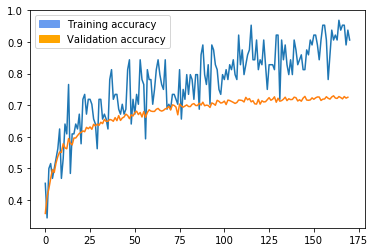

In [31]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

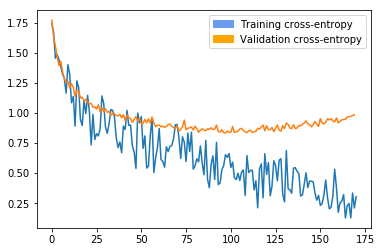

In [32]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [ ]:
test_acc = session.run(accuracy, feed_dict={
    inputs: test_data_norm, targets: test_labels_ohe, keep_prob: 1.})
print("Test data accuracy: " + str(test_acc))

In [ ]:
session.close()